<a href="https://colab.research.google.com/github/k-vinamr/rera_construction_pred/blob/main/6_floor_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
# Load your dataset
data = pd.read_csv('augmented_6_floor.csv')

In [2]:
data

,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,total_days,Cleaning & survey,...,Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,duration_since_commencement,remaining_duration,progress_ratio,current_stage,area_bin
0,NITIN Last Name DOLKE,Residential/Group Housing,2/16/2022,6/2/2022,1251.720000,480.000000,6,MAHARASHTRA,106,0.633214,...,9.498208,7.598566,10.131422,5.698925,8.864994,616,-511,5.811321,completed,"(1000, 1500]"
1,SARYASH CONSTRUCTIONS,Residential/Group Housing,4/13/2018,7/31/2018,464.660000,279.000000,6,MAHARASHTRA,109,0.651135,...,9.767025,7.813620,10.418160,5.860215,9.115890,2021,-1913,18.541284,completed,"(0, 500]"
2,Murtuz Abdul Razzaque Kotkunde,Residential/Group Housing,9/13/2021,12/31/2021,417.710000,226.600000,6,MAHARASHTRA,109,0.651135,...,9.767025,7.813620,10.418160,5.860215,9.115890,772,-664,7.082569,completed,"(0, 500]"
3,PATIL AND MANURE ASSOCIATES,Residential/Group Housing,9/9/2021,12/30/2021,690.650000,511.500000,6,MAHARASHTRA,112,0.669056,...,10.035842,8.028674,10.704898,6.021505,9.366786,776,-665,6.928571,completed,"(500, 1000]"
4,GANGA BUILDERS AND DEVELOPERS,Residential/Group Housing,9/9/2021,12/30/2021,965.400000,471.000000,6,MAHARASHTRA,112,0.669056,...,10.035842,8.028674,10.704898,6.021505,9.366786,776,-665,6.928571,completed,"(500, 1000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NISHANT JAGANNATH PAWAR,Residential/Group Housing,3/17/2022,12/29/2026,957.849683,318.672763,6,MAHARASHTRA,1748,10.489845,...,157.347670,125.878136,167.837515,94.408602,146.857826,593,1162,0.337699,running,"(500, 1000]"
9996,Shri Balaji Developers,Residential/Group Housing,10/28/2022,11/7/2025,5986.899972,1258.691588,6,Rajasthan,1106,6.547192,...,98.207885,78.566308,104.755078,58.924731,91.660693,359,736,0.327555,running,"(5500, 6000]"
9997,S G BUILDCON,Residential/Group Housing,1/17/2023,10/4/2026,1266.691004,394.986042,6,MAHARASHTRA,1356,8.034648,...,120.519713,96.415771,128.554361,72.311828,112.485066,274,1070,0.203717,running,"(1000, 1500]"
9998,SANJAY BALGOUNDA PATIL,Residential/Group Housing,12/1/2018,3/26/2019,1182.358116,975.010847,6,MAHARASHTRA,115,0.728793,...,10.931900,8.745520,11.660693,6.559140,10.203106,1791,-1670,14.680328,completed,"(1000, 1500]"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   organisation_name                                                          10000 non-null  object 
 1   project_category                                                           10000 non-null  object 
 2   actual_commencement_date                                                   10000 non-null  object 
 3   estimated_finish_date                                                      10000 non-null  object 
 4   total_built_up_area_saleable_area                                          10000 non-null  float64
 5   total_area_of_project                                                      10000 non-null  float64
 6   floor                                                  

In [4]:
# Converting date columns to datetime objects
data['actual_commencement_date'] = pd.to_datetime(data['actual_commencement_date'], errors='coerce')
data['estimated_finish_date'] = pd.to_datetime(data['estimated_finish_date'], errors='coerce')

In [5]:
current_date = datetime.now()

In [6]:
data['duration_since_commencement'] = (current_date - data['actual_commencement_date']).dt.days
data['remaining_duration'] = (data['estimated_finish_date'] - current_date).dt.days
data['progress_ratio'] = data['duration_since_commencement'] / data['total_days']

In [7]:
# Define a function to determine the project status
def determine_status(row):
    if current_date > row['estimated_finish_date']:
        return 'completed'
    elif current_date >= row['actual_commencement_date']:
        return 'running'
    else:
        return 'upcoming'

# Apply the function to create the 'Status' column
data['current_stage'] = data.apply(determine_status, axis=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                                                                     Non-Null Count  Dtype         
---  ------                                                                     --------------  -----         
 0   organisation_name                                                          10000 non-null  object        
 1   project_category                                                           10000 non-null  object        
 2   actual_commencement_date                                                   10000 non-null  datetime64[ns]
 3   estimated_finish_date                                                      10000 non-null  datetime64[ns]
 4   total_built_up_area_saleable_area                                          10000 non-null  float64       
 5   total_area_of_project                                                      10000 non-null  float64       
 6  

In [9]:
data

,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,total_days,Cleaning & survey,...,Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,duration_since_commencement,remaining_duration,progress_ratio,current_stage,area_bin
0,NITIN Last Name DOLKE,Residential/Group Housing,2022-02-16,2022-06-02,1251.720000,480.000000,6,MAHARASHTRA,106,0.633214,...,9.498208,7.598566,10.131422,5.698925,8.864994,630,-525,5.943396,completed,"(1000, 1500]"
1,SARYASH CONSTRUCTIONS,Residential/Group Housing,2018-04-13,2018-07-31,464.660000,279.000000,6,MAHARASHTRA,109,0.651135,...,9.767025,7.813620,10.418160,5.860215,9.115890,2035,-1927,18.669725,completed,"(0, 500]"
2,Murtuz Abdul Razzaque Kotkunde,Residential/Group Housing,2021-09-13,2021-12-31,417.710000,226.600000,6,MAHARASHTRA,109,0.651135,...,9.767025,7.813620,10.418160,5.860215,9.115890,786,-678,7.211009,completed,"(0, 500]"
3,PATIL AND MANURE ASSOCIATES,Residential/Group Housing,2021-09-09,2021-12-30,690.650000,511.500000,6,MAHARASHTRA,112,0.669056,...,10.035842,8.028674,10.704898,6.021505,9.366786,790,-679,7.053571,completed,"(500, 1000]"
4,GANGA BUILDERS AND DEVELOPERS,Residential/Group Housing,2021-09-09,2021-12-30,965.400000,471.000000,6,MAHARASHTRA,112,0.669056,...,10.035842,8.028674,10.704898,6.021505,9.366786,790,-679,7.053571,completed,"(500, 1000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NISHANT JAGANNATH PAWAR,Residential/Group Housing,2022-03-17,2026-12-29,957.849683,318.672763,6,MAHARASHTRA,1748,10.489845,...,157.347670,125.878136,167.837515,94.408602,146.857826,601,1146,0.343822,running,"(500, 1000]"
9996,Shri Balaji Developers,Residential/Group Housing,2022-10-28,2025-11-07,5986.899972,1258.691588,6,Rajasthan,1106,6.547192,...,98.207885,78.566308,104.755078,58.924731,91.660693,376,729,0.339964,running,"(5500, 6000]"
9997,S G BUILDCON,Residential/Group Housing,2023-01-17,2026-10-04,1266.691004,394.986042,6,MAHARASHTRA,1356,8.034648,...,120.519713,96.415771,128.554361,72.311828,112.485066,295,1060,0.217552,running,"(1000, 1500]"
9998,SANJAY BALGOUNDA PATIL,Residential/Group Housing,2018-12-01,2019-03-26,1182.358116,975.010847,6,MAHARASHTRA,115,0.728793,...,10.931900,8.745520,11.660693,6.559140,10.203106,1803,-1689,15.678261,completed,"(1000, 1500]"


In [10]:
# Performing label encoding on the 'current_stage' column
label_encoder = LabelEncoder()
data['current_stage'] = data['current_stage'].astype(str) # Converting to string to handle any NaN values left
data['current_stage_encoded'] = label_encoder.fit_transform(data['current_stage'])

In [11]:
# Performing label encoding on the 'current_stage' column
label_encoder = LabelEncoder()
data['project_state'] = data['project_state'].astype(str) # Converting to string to handle any NaN values left
data['project_state_encoded'] = label_encoder.fit_transform(data['project_state'])

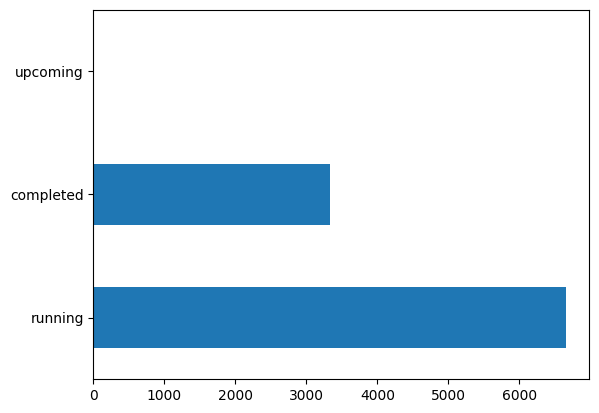

In [12]:
(data['current_stage'].value_counts()).plot(kind='barh'); plt.show()

In [13]:
data['total_days'].describe()

count    10000.000000
mean       923.069200
std        469.264051
min         95.000000
25%        592.000000
50%        884.000000
75%       1140.000000
max       3772.000000
Name: total_days, dtype: float64

In [14]:
# Feature selection - use relevant features for input
numerical_columns = data.select_dtypes(include=['int64', 'float64'])
stage_columns = [ 'Cleaning & survey',
 'Excavation,leveling & P.C.C  for Basement  B1 ',
 ' Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ',
 'Slab of B (bottom) ',
 ' Ground Floor slab casting ',
 ' 1st floor Columns casting',
 ' 1st Floor slab casting',
 '2nd floor Columns casting ',
 '2nd Floor slab casting',
 ' Brick work at Basement to Ground Floor ',
 '3rd floor Columns casting ',
 '3rd Floor slab casting',
 ' Brick work at 1st Floor ',
 'Electrical concealed, PVC Fitting, plastering at basement- ground floor',
 '4th floor Columns casting ',
 '4th Floor slab casting',
 ' Brick work at 2nd Floor ',
 'Electrical concealed, PVC Fitting, plastering at 1st floor',
 '5th floor Columns casting ',
 '5th Floor slab casting',
 ' Brick work at 3rd Floor ',
 'Electrical concealed, PVC Fitting, plastering at 2nd floor',
 '6th floor Columns casting ',
 '6th Floor slab casting',
 ' Brick work of 4th to 6th Floor ',
 'Electrical concealed, PVC Fitting, plastering at 3rd-6th floor',
 'Plastering on outer sides',
 'Tiles work',
 'Painting and Finishing',
 'Plumbing & Sanitary,Electrification Works',
 'Doors & Windows Fixing Furniture work']
# Target variables
X = data[numerical_columns.columns.difference(stage_columns)].drop(columns='total_days')
y_total_days = data['total_days']
y_time_taken_at_each_stage = data[stage_columns]  # Replace with your actual stage columns

In [15]:
X.columns

Index(['current_stage_encoded', 'duration_since_commencement', 'floor',
       'progress_ratio', 'project_state_encoded', 'remaining_duration',
       'total_area_of_project', 'total_built_up_area_saleable_area'],
      dtype='object')

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have loaded your data and defined 'X' and 'y_total_days' as specified

# Split the data into training and testing sets
X_train, X_test, y_train_total_days, y_test_total_days = train_test_split(
    X, y_total_days, test_size=0.2, random_state=42)

# Create a function to train a Random Forest regression model, make predictions, and evaluate its performance
def train_evaluate_model(X_train, X_test, y_train_total_days, y_test_total_day):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train_total_days)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test_total_days, y_pred)
    r2 = r2_score(y_test_total_days, y_pred)
    return mse, r2

# Initial model performance
initial_mse, initial_r2 = train_evaluate_model(X_train, X_test, y_train_total_days, y_test_total_days)
feature_impact = {}

for column in X.columns:
    X_temp = X.drop(columns=[column])
    mse, r2 = train_evaluate_model(X_train, X_test, y_train_total_days, y_test_total_days)
    mse_change = initial_mse - mse
    r2_change = r2 - initial_r2
    feature_impact[column] = {'MSE Change': mse_change, 'R-squared Change': r2_change}

# Print the impact of removing each feature
for column, impact in feature_impact.items():
    print(f"Removed '{column}':")
    print(f"MSE Change: {impact['MSE Change']:.2f}")
    print(f"R-squared Change: {impact['R-squared Change']:.4f}\n")


Removed 'current_stage_encoded':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'duration_since_commencement':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'floor':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'progress_ratio':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'project_state_encoded':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'remaining_duration':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'total_area_of_project':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'total_built_up_area_saleable_area':
MSE Change: 0.00
R-squared Change: 0.0000



In [17]:
# Train a Random Forest model on the entire dataset
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y_total_days)

# Get feature importances
importances = model.feature_importances_

# Pair feature names with their importance scores
feature_importance = list(zip(X.columns, importances))

# Sort features by importance (in descending order)
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature, importance in feature_importance:
    print(f"{feature}: {importance:.4f}")

remaining_duration: 0.6843
duration_since_commencement: 0.1697
progress_ratio: 0.1431
total_area_of_project: 0.0016
total_built_up_area_saleable_area: 0.0010
project_state_encoded: 0.0002
current_stage_encoded: 0.0001
floor: 0.0000


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train_total_days, y_test_total_days, y_train_time, y_test_time = train_test_split(
    X, y_total_days, y_time_taken_at_each_stage, test_size=0.2, random_state=42)

# Create and train the regression model for total days
total_days_model = RandomForestRegressor(n_estimators=100, random_state=42)
total_days_model.fit(X_train, y_train_total_days)

# Predict total days on the test set
y_pred_total_days = total_days_model.predict(X_test)

# Evaluate the model for total days
mse_total_days = mean_squared_error(y_test_total_days, y_pred_total_days)
r2_total_days = r2_score(y_test_total_days, y_pred_total_days)
print(f'Mean Squared Error (Total Days): {mse_total_days}')
print(f'R-squared (Total Days): {r2_total_days}')

Mean Squared Error (Total Days): 84.3523479
R-squared (Total Days): 0.9996218172686296


In [19]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
# Define a custom scorer for cross-validation
mse_scorer = make_scorer(mean_squared_error)  # Use make_scorer to create the custom scorer

# Perform K-Fold Cross-Validation
k = 5  # You can adjust the number of folds
cv_scores = cross_val_score(total_days_model, X, y_total_days, cv=k, scoring=mse_scorer)

# Print the mean and standard deviation of MSE scores
print("Cross-Validation Mean MSE:", np.mean(cv_scores))
print("Cross-Validation MSE Std Dev:", np.std(cv_scores))


Cross-Validation Mean MSE: 52.170109780000004
Cross-Validation MSE Std Dev: 9.417011497932553


In [20]:
# Create and train the regression model for time taken at each stage
stage_models = {}
for stage in stage_columns:
    stage_model = RandomForestRegressor(n_estimators=100, random_state=42)
    stage_model.fit(X_train, y_train_time[stage])
    stage_models[stage] = stage_model

# Predict time taken at each stage on the test set
y_pred_time = {}
for stage, stage_model in stage_models.items():
    y_pred_time[stage] = stage_model.predict(X_test)

In [21]:
# Assuming you have already converted 'actual_commencement_date' to a datetime object
# Calculate days elapsed for each project
current_date = datetime.now()
data['days_elapsed'] = (current_date - data['actual_commencement_date']).dt.days

# Define a function to determine the relevant stage and relevant columns for each project
def determine_relevant_stage_and_columns(row):
    days_elapsed = row['days_elapsed']
    total_days = 0
    relevant_stage = None
    relevant_columns = []

    for stage in stage_columns:
        stage_duration = row[stage]  # Days required for the current stage
        total_days += stage_duration
        if total_days >= days_elapsed:
            relevant_stage = stage
            relevant_columns = [stage for stage in stage_columns[stage_columns.index(stage):]]
            break

    return relevant_stage, relevant_columns, total_days

# Apply the function to create the 'relevant_stage' and 'relevant_columns' columns
data[['relevant_stage', 'relevant_columns', 'total_days']] = data.apply(determine_relevant_stage_and_columns, axis=1, result_type='expand')

# Filter projects based on current_stage
completed_projects = data[data['current_stage'] == 'completed']
running_projects = data[data['current_stage'] == 'running']
upcoming_projects = data[data['current_stage'] == 'upcoming']

# Define a function to make predictions based on the current stage
def make_predictions(row):
    if row['current_stage'] == 'completed':
        return None  # No predictions for completed projects
    elif row['current_stage'] == 'running':
        if row['relevant_stage'] is not None:
            if row['relevant_stage'] in row['relevant_columns']:
                return row[row['relevant_stage']] - (row['days_elapsed'] - row['total_days'])
            else:
                return None  # Skip stages before the relevant stage
        else:
            return None  # Skip predictions for running projects with no relevant stage
    elif row['current_stage'] == 'upcoming':
        return row['total_days']  # Include all stages for upcoming projects

# Apply the make_predictions function to create the 'predicted_time_taken' column
data['predicted_time_taken'] = data.apply(make_predictions, axis=1)


In [22]:
# Evaluate the models for time taken at each stage
mse_stage = {}
r2_stage = {}
for stage in stage_columns:
    mse_stage[stage] = mean_squared_error(y_test_time[stage], y_pred_time[stage])
    r2_stage[stage] = r2_score(y_test_time[stage], y_pred_time[stage])
    print(f'Mean Squared Error ({stage}): {mse_stage[stage]}')
    print(f'R-squared ({stage}): {r2_stage[stage]}')

Mean Squared Error (Cleaning & survey): 0.0035634766678731026
R-squared (Cleaning & survey): 0.9995523546236115
Mean Squared Error (Excavation,leveling & P.C.C  for Basement  B1 ): 0.05368804001978188
R-squared (Excavation,leveling & P.C.C  for Basement  B1 ): 0.9995784804223204
Mean Squared Error ( Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ): 0.10002921787726803
R-squared ( Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ): 0.999569077136587
Mean Squared Error (Slab of B (bottom) ): 0.03181026550293647
R-squared (Slab of B (bottom) ): 0.9995559979573894
Mean Squared Error ( Ground Floor slab casting ): 0.11288508730691463
R-squared ( Ground Floor slab casting ): 0.9995478102614623
Mean Squared Error ( 1st floor Columns casting): 0.017134324671594734
R-squared ( 1st floor Columns casting): 0.9995552849635331
Mean Squared Error ( 1st Floor slab casting): 0.05368804001978188
R-squared ( 1st Floor slab casting): 0.9995784804223204
Mean

In [23]:
# Load the new data (replace 'new_data.csv' with the actual file path)
new_data = pd.read_csv('new_6_test_file.csv')

In [24]:
# Converting date columns to datetime objeacts
new_data['actual_commencement_date'] = pd.to_datetime(new_data['actual_commencement_date'], errors='coerce')
new_data['estimated_finish_date'] = pd.to_datetime(new_data['estimated_finish_date'], errors='coerce')

<ipython-input-24-eb2634250976>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  new_data['actual_commencement_date'] = pd.to_datetime(new_data['actual_commencement_date'], errors='coerce')
<ipython-input-24-eb2634250976>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  new_data['estimated_finish_date'] = pd.to_datetime(new_data['estimated_finish_date'], errors='coerce')


In [25]:
current_date = datetime.now()

In [26]:
new_data['total_days'] = (new_data['estimated_finish_date'] - new_data['actual_commencement_date']).dt.days

In [27]:
new_data['duration_since_commencement'] = (current_date - new_data['actual_commencement_date']).dt.days
new_data['remaining_duration'] = (new_data['estimated_finish_date'] - current_date).dt.days
new_data['progress_ratio'] = new_data['duration_since_commencement'] / new_data['total_days']

In [28]:
# Define a function to determine the project status
def determine_status(row):
    if current_date > row['estimated_finish_date']:
        return 'completed'
    elif current_date >= row['actual_commencement_date']:
        return 'running'
    else:
        return 'upcoming'

# Apply the function to create the 'Status' column
new_data['current_stage'] = new_data.apply(determine_status, axis=1)

In [29]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   organisation_name                  1224 non-null   object        
 1   project_category                   1224 non-null   object        
 2   actual_commencement_date           1224 non-null   datetime64[ns]
 3   estimated_finish_date              1224 non-null   datetime64[ns]
 4   total_built_up_area_saleable_area  1224 non-null   float64       
 5   total_area_of_project              1224 non-null   float64       
 6   floor                              1224 non-null   int64         
 7   project_state                      1224 non-null   object        
 8   office_no                          1224 non-null   float64       
 9   project_res_no                     1224 non-null   object        
 10  total_days                         1

In [30]:
new_data

,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,office_no,project_res_no,total_days,duration_since_commencement,remaining_duration,progress_ratio,current_stage
0,Shilp Constructions,Residential/Group Housing,2017-07-29,2018-06-30,699.68,397.50,6,MAHARASHTRA,0.000000e+00,AHMED2S_AMra3s_AUR7S_TH1S_793500,336,2293,-1958,6.824405,completed
1,ABC AND MITTAL REALTY,Residential/Group Housing,2017-07-29,2018-06-30,2149.53,1918.45,6,MAHARASHTRA,2.066307e+09,PUNE_Two_372000,336,2293,-1958,6.824405,completed
2,VASUDHA DEVELOPERS,Residential/Group Housing,2022-01-29,2022-12-31,1390.16,790.00,6,MAHARASHTRA,2.512586e+09,THANE12S_448000,336,648,-313,1.928571,completed
3,Sarthak & Shanti Associates,Residential/Group Housing,2017-07-29,2018-06-30,2160.00,1800.00,6,MAHARASHTRA,2.025466e+09,PUNE_One_539500,336,2293,-1958,6.824405,completed
4,Mahalaxmi Builders & Developers,Residential/Group Housing,2022-01-29,2022-12-31,436.20,278.00,6,MAHARASHTRA,9.762530e+09,PUNE_Two_1500,336,648,-313,1.928571,completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,SARWDNYA BUILDCON,Residential/Group Housing,2022-01-04,2029-12-31,2351.60,837.00,6,MAHARASHTRA,9.423184e+09,Sindh3s_Wardha2s_NASIK8S_790000,2918,673,2244,0.230637,running
1220,ABHISHEK SUBHASH NIKAM,Residential/Group Housing,2022-10-27,2030-12-31,9163.48,3557.30,6,MAHARASHTRA,9.765000e+09,Jalga2s_Chand2s_Sola3_Sat6s_906500,2987,377,2609,0.126214,running
1221,MANSI BUILDERS AND DEVELOPERS,Residential/Group Housing,2021-09-09,2030-03-31,9597.12,9100.00,6,MAHARASHTRA,2.024223e+09,PUNE_Three_327000,3125,790,2334,0.252800,running
1222,DATTATRAY DINKAR CHAVAN,Residential/Group Housing,2022-12-12,2032-12-31,2398.58,1700.50,6,MAHARASHTRA,9.822688e+09,Jalga2s_Chand2s_Sola3_Sat6s_823000,3672,331,3340,0.090142,running


In [31]:
# Performing label encoding on the 'current_stage' column
label_encoder = LabelEncoder()
new_data['current_stage'] =new_data['current_stage'].astype(str) # Converting to string to handle any NaN values left
new_data['current_stage_encoded'] = label_encoder.fit_transform(new_data['current_stage'])

In [32]:
# Performing label encoding on the 'current_stage' column
label_encoder = LabelEncoder()
new_data['project_state'] =new_data['project_state'].astype(str) # Converting to string to handle any NaN values left
new_data['project_state_encoded'] = label_encoder.fit_transform(new_data['project_state'])


In [33]:
new_data['office_no'] = new_data['office_no'].astype(str)

In [34]:
stage_columns = [ 'Cleaning & survey',
 'Excavation,leveling & P.C.C  for Basement  B1 ',
 ' Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ',
 'Slab of B (bottom) ',
 ' Ground Floor slab casting ',
 ' 1st floor Columns casting',
 ' 1st Floor slab casting',
 '2nd floor Columns casting ',
 '2nd Floor slab casting',
 ' Brick work at Basement to Ground Floor ',
 '3rd floor Columns casting ',
 '3rd Floor slab casting',
 ' Brick work at 1st Floor ',
 'Electrical concealed, PVC Fitting, plastering at basement- ground floor',
 '4th floor Columns casting ',
 '4th Floor slab casting',
 ' Brick work at 2nd Floor ',
 'Electrical concealed, PVC Fitting, plastering at 1st floor',
 '5th floor Columns casting ',
 '5th Floor slab casting',
 ' Brick work at 3rd Floor ',
 'Electrical concealed, PVC Fitting, plastering at 2nd floor',
 '6th floor Columns casting ',
 '6th Floor slab casting',
 ' Brick work of 4th to 6th Floor ',
 'Electrical concealed, PVC Fitting, plastering at 3rd-6th floor',
 'Plastering on outer sides',
 'Tiles work',
 'Painting and Finishing',
 'Plumbing & Sanitary,Electrification Works',
 'Doors & Windows Fixing Furniture work']

In [35]:
# Create an empty DataFrame to store 'new_data' with added columns
new_data = new_data.copy()  # Assuming 'new_data' is your original DataFrame

# Add stage-related columns and 'total_days' column with NaN values
for stage in stage_columns:
    new_data[stage] = np.nan

new_data['total_days'] = np.nan

# Now, 'new_data_with_stages' contains the additional columns with NaN values


In [36]:
numerical_columns = new_data.select_dtypes(include=['int64', 'float64'])
stage_columns = [ 'Cleaning & survey',
 'Excavation,leveling & P.C.C  for Basement  B1 ',
 ' Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ',
 'Slab of B (bottom) ',
 ' Ground Floor slab casting ',
 ' 1st floor Columns casting',
 ' 1st Floor slab casting',
 '2nd floor Columns casting ',
 '2nd Floor slab casting',
 ' Brick work at Basement to Ground Floor ',
 '3rd floor Columns casting ',
 '3rd Floor slab casting',
 ' Brick work at 1st Floor ',
 'Electrical concealed, PVC Fitting, plastering at basement- ground floor',
 '4th floor Columns casting ',
 '4th Floor slab casting',
 ' Brick work at 2nd Floor ',
 'Electrical concealed, PVC Fitting, plastering at 1st floor',
 '5th floor Columns casting ',
 '5th Floor slab casting',
 ' Brick work at 3rd Floor ',
 'Electrical concealed, PVC Fitting, plastering at 2nd floor',
 '6th floor Columns casting ',
 '6th Floor slab casting',
 ' Brick work of 4th to 6th Floor ',
 'Electrical concealed, PVC Fitting, plastering at 3rd-6th floor',
 'Plastering on outer sides',
 'Tiles work',
 'Painting and Finishing',
 'Plumbing & Sanitary,Electrification Works',
 'Doors & Windows Fixing Furniture work']
# Target variables
X_new = new_data[numerical_columns.columns.difference(stage_columns)].drop(columns='total_days')
#y_total_days = new_data['total_days']
#y_time_taken_at_each_stage = new_data[stage_columns]  # Replace with your actual stage columns

In [37]:
new_data['total_days'] = total_days_model.predict(new_data[X_new.columns])

for stage in stage_columns:
    stage_model = stage_models.get(stage)  # Use get to avoid KeyError
    if stage_model:
        new_data[stage] = stage_model.predict(new_data[X_new.columns])
    else:
        # If the stage column isn't in stage_models, fill it with NaN
        new_data[stage] = np.nan

In [38]:
new_data

,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,office_no,project_res_no,...,"Electrical concealed, PVC Fitting, plastering at 2nd floor",6th floor Columns casting,6th Floor slab casting,Brick work of 4th to 6th Floor,"Electrical concealed, PVC Fitting, plastering at 3rd-6th floor",Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work
0,Shilp Constructions,Residential/Group Housing,2017-07-29,2018-06-30,699.68,397.50,6,MAHARASHTRA,0.0,AHMED2S_AMra3s_AUR7S_TH1S_793500,...,8.448172,5.232151,8.863608,11.298017,28.178973,30.237455,24.144086,32.222700,18.158065,28.178973
1,ABC AND MITTAL REALTY,Residential/Group Housing,2017-07-29,2018-06-30,2149.53,1918.45,6,MAHARASHTRA,2066306521.0,PUNE_Two_372000,...,8.430108,5.218638,8.831541,11.240143,28.100358,30.107527,24.086022,32.114695,18.064516,28.100358
2,VASUDHA DEVELOPERS,Residential/Group Housing,2022-01-29,2022-12-31,1390.16,790.00,6,MAHARASHTRA,2512585727.0,THANE12S_448000,...,8.439642,5.224540,8.841529,11.252855,28.132139,30.141577,24.113262,32.151016,18.084946,28.132139
3,Sarthak & Shanti Associates,Residential/Group Housing,2017-07-29,2018-06-30,2160.00,1800.00,6,MAHARASHTRA,2025465944.0,PUNE_One_539500,...,8.430108,5.218638,8.831541,11.240143,28.100358,30.107527,24.086022,32.114695,18.064516,28.100358
4,Mahalaxmi Builders & Developers,Residential/Group Housing,2022-01-29,2022-12-31,436.20,278.00,6,MAHARASHTRA,9762529898.0,PUNE_Two_1500,...,8.418315,5.203572,8.801051,11.199665,28.045161,29.998208,23.985663,31.986619,18.015591,28.045161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,SARWDNYA BUILDCON,Residential/Group Housing,2022-01-04,2029-12-31,2351.60,837.00,6,MAHARASHTRA,9423184165.0,Sindh3s_Wardha2s_NASIK8S_790000,...,70.755950,43.878495,74.101888,94.439952,235.943489,252.675627,202.516129,269.503465,151.887097,235.943489
1220,ABHISHEK SUBHASH NIKAM,Residential/Group Housing,2022-10-27,2030-12-31,9163.48,3557.30,6,MAHARASHTRA,9764999944.0,Jalga2s_Chand2s_Sola3_Sat6s_906500,...,85.185735,52.876918,89.218017,113.550203,284.106332,304.317204,243.519713,324.868817,182.639785,284.106332
1221,MANSI BUILDERS AND DEVELOPERS,Residential/Group Housing,2021-09-09,2030-03-31,9597.12,9100.00,6,MAHARASHTRA,2024223089.0,PUNE_Three_327000,...,70.755950,43.832676,74.119761,94.439952,235.696774,252.675627,202.516129,269.221505,151.887097,235.696774
1222,DATTATRAY DINKAR CHAVAN,Residential/Group Housing,2022-12-12,2032-12-31,2398.58,1700.50,6,MAHARASHTRA,9822687755.0,Jalga2s_Chand2s_Sola3_Sat6s_823000,...,92.129032,57.032258,96.516129,122.838710,307.096774,329.032258,263.225806,350.967742,197.419355,307.096774


In [39]:
# Write the DataFrame to an Excel file
# Define file paths

excel_file = "output_augmented_file.xlsx"
sheet_name = "Sheet1"
new_data.to_excel(excel_file, sheet_name=sheet_name, index=False)

print("Excel file saved:", excel_file)

Excel file saved: output_augmented_file.xlsx


In [40]:
# Create a dictionary to map stages to materials
stage_materials = {
    'Cleaning & survey': [],
    'Excavation,leveling & P.C.C for Basement B1': ['cement', 'sand', 'aggregates'],
    'Raft footing, Column B1, Retaining wall Reinforcement, Concrete pouring': ['TMT bar', 'cement', 'sand', 'aggregates'],
    'Slab of B (bottom)': ['TMT bar', 'cement', 'sand', 'aggregates'],
    'Ground Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'Pvc pipes', 'circuit pipes', 'lightbox', 'fan box'],
    '1st floor Columns casting': ['TMT bar', 'cement', 'sand', 'aggregates'],
    '1st Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'Pvc pipes', 'circuit pipes', 'lightbox', 'fan box'],
    '2nd floor Columns casting': ['TMT bar', 'cement', 'sand', 'aggregates'],
    '2nd Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'Pvc pipes', 'circuit pipes', 'lightbox', 'fan box'],
    'Brick work at Basement to Ground Floor': ['blocks/bricks'],
    '3rd floor Columns casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'Pvc pipes', 'circuit pipes', 'lightbox', 'fan box'],
    '3rd Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates'],
    'Brick work at 1st Floor': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at basement- ground floor': ['cement', 'sand', 'circuit pipe', 'Cpvc', '&Pvc pipe'],
    '4th floor Columns casting': ['TMT bar', 'cement', 'sand', 'aggregates'],
    '4th Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'Pvc pipes', 'circuit pipes', 'lightbox', 'fan box'],
    'Brick work at 2nd Floor': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at 1st floor': ['cement', 'sand', 'circuit pipe', 'Cpvc', '&Pvc pipe'],
    '5th floor Columns casting': ['TMT bar', 'cement', 'sand', 'aggregates'],
    '5th Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'Pvc pipes', 'circuit pipes', 'lightbox', 'fan box'],
    'Brick work at 3rd Floor': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at 2nd floor': ['cement', 'sand', 'circuit pipe', 'Cpvc', '&Pvc pipe'],
    '6th floor Columns casting': ['TMT bar', 'cement', 'sand', 'aggregates'],
    '6th Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'Pvc pipes', 'circuit pipes', 'lightbox', 'fan box'],
    'Brick work of 4th to 6th Floor': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at 3rd-6th floor': ['cement', 'sand', 'circuit pipe', 'Cpvc', '&Pvc pipe'],
    'Plastering on outer sides': ['cement', 'sand'],
    'Tiles work': ['Tiles'],
    'Painting and Finishing': ['paint', 'putty', 'primer'],
    'Plumbing & Sanitary,Electrification Works': ['Wire', 'switch', 'nozzle Bib cock', 'shower', 'kitchen accessories', 'lights', 'fans', 'sheets', 'basin', 'sink', 'etc.'],
    'Doors & Windows Fixing Furniture work': ['Furniture', 'hardware', 'glass'],
}


In [41]:
# Initialize empty lists to store relevant_stage and relevant_columns
relevant_stage_list = []
relevant_columns_list = []

# Iterate through each row (project) in new_data
for index, row in new_data.iterrows():
    days_elapsed = (current_date - row['actual_commencement_date']).days
    total_days = row['total_days']

    relevant_stage = None
    relevant_columns = []

    for stage in reversed(stage_columns):  # Reverse the order of stage_columns

        if total_days is None or np.isnan(total_days):
            # Set relevant_stage and relevant_columns to None if total_days is missing
            relevant_stage = None
            relevant_columns = []
            break

        stage_duration = row[stage]
        total_days -= stage_duration

        if total_days <= days_elapsed:
            relevant_stage = stage
            relevant_columns = [stage for stage in stage_columns[stage_columns.index(stage):]]
            break

    relevant_stage_list.append(relevant_stage)
    relevant_columns_list.append(relevant_columns)

# Add the 'relevant_stage' and 'relevant_columns' columns to the new_data DataFrame
new_data['relevant_stage'] = relevant_stage_list
new_data['relevant_columns'] = relevant_columns_list

In [42]:
import pandas as pd
import numpy as np

# Initialize empty DataFrame to store adjusted days data
adjusted_days_data = pd.DataFrame(columns=stage_columns)

# Iterate through each row (project) in new_data
for index, row in new_data.iterrows():
    current_stage = row['current_stage']
    relevant_columns = row['relevant_columns']

    if current_stage == 'completed':
        # For completed projects, set 'days' to NaN for all stage columns
        days_values = [np.nan] * len(stage_columns)
    elif current_stage == 'running':
        # For running projects, update 'days' based on relevant_columns
        days_values = [row[stage] if stage in relevant_columns else np.nan for stage in stage_columns]
    elif current_stage == 'upcoming':
        # For upcoming projects, keep the predicted 'days' values
        days_values = [row[stage] for stage in stage_columns]

    # Append the days_values to the adjusted_days_data
    adjusted_days_data = adjusted_days_data.append(pd.Series(days_values, index=stage_columns), ignore_index=True)

# Replace the original stage values in new_data with adjusted values
new_data[stage_columns] = adjusted_days_data

<ipython-input-42-06976df5c563>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adjusted_days_data = adjusted_days_data.append(pd.Series(days_values, index=stage_columns), ignore_index=True)
<ipython-input-42-06976df5c563>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adjusted_days_data = adjusted_days_data.append(pd.Series(days_values, index=stage_columns), ignore_index=True)
<ipython-input-42-06976df5c563>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adjusted_days_data = adjusted_days_data.append(pd.Series(days_values, index=stage_columns), ignore_index=True)
<ipython-input-42-06976df5c563>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

In [43]:
new_data

,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,office_no,project_res_no,...,6th Floor slab casting,Brick work of 4th to 6th Floor,"Electrical concealed, PVC Fitting, plastering at 3rd-6th floor",Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,relevant_stage,relevant_columns
0,Shilp Constructions,Residential/Group Housing,2017-07-29,2018-06-30,699.68,397.50,6,MAHARASHTRA,0.0,AHMED2S_AMra3s_AUR7S_TH1S_793500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Doors & Windows Fixing Furniture work,[Doors & Windows Fixing Furniture work]
1,ABC AND MITTAL REALTY,Residential/Group Housing,2017-07-29,2018-06-30,2149.53,1918.45,6,MAHARASHTRA,2066306521.0,PUNE_Two_372000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Doors & Windows Fixing Furniture work,[Doors & Windows Fixing Furniture work]
2,VASUDHA DEVELOPERS,Residential/Group Housing,2022-01-29,2022-12-31,1390.16,790.00,6,MAHARASHTRA,2512585727.0,THANE12S_448000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Doors & Windows Fixing Furniture work,[Doors & Windows Fixing Furniture work]
3,Sarthak & Shanti Associates,Residential/Group Housing,2017-07-29,2018-06-30,2160.00,1800.00,6,MAHARASHTRA,2025465944.0,PUNE_One_539500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Doors & Windows Fixing Furniture work,[Doors & Windows Fixing Furniture work]
4,Mahalaxmi Builders & Developers,Residential/Group Housing,2022-01-29,2022-12-31,436.20,278.00,6,MAHARASHTRA,9762529898.0,PUNE_Two_1500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Doors & Windows Fixing Furniture work,[Doors & Windows Fixing Furniture work]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,SARWDNYA BUILDCON,Residential/Group Housing,2022-01-04,2029-12-31,2351.60,837.00,6,MAHARASHTRA,9423184165.0,Sindh3s_Wardha2s_NASIK8S_790000,...,74.101888,94.439952,235.943489,252.675627,202.516129,269.503465,151.887097,235.943489,3rd Floor slab casting,"[3rd Floor slab casting, Brick work at 1st Fl..."
1220,ABHISHEK SUBHASH NIKAM,Residential/Group Housing,2022-10-27,2030-12-31,9163.48,3557.30,6,MAHARASHTRA,9764999944.0,Jalga2s_Chand2s_Sola3_Sat6s_906500,...,89.218017,113.550203,284.106332,304.317204,243.519713,324.868817,182.639785,284.106332,Ground Floor slab casting,"[ Ground Floor slab casting , 1st floor Colum..."
1221,MANSI BUILDERS AND DEVELOPERS,Residential/Group Housing,2021-09-09,2030-03-31,9597.12,9100.00,6,MAHARASHTRA,2024223089.0,PUNE_Three_327000,...,74.119761,94.439952,235.696774,252.675627,202.516129,269.221505,151.887097,235.696774,"Electrical concealed, PVC Fitting, plastering ...","[Electrical concealed, PVC Fitting, plastering..."
1222,DATTATRAY DINKAR CHAVAN,Residential/Group Housing,2022-12-12,2032-12-31,2398.58,1700.50,6,MAHARASHTRA,9822687755.0,Jalga2s_Chand2s_Sola3_Sat6s_823000,...,96.516129,122.838710,307.096774,329.032258,263.225806,350.967742,197.419355,307.096774,Ground Floor slab casting,"[ Ground Floor slab casting , 1st floor Colum..."


In [44]:
# Assuming 'new_data' is your DataFrame

# Find the row for the organization "NATHKRUPA DEVELOPERS"
organization_name_to_check = "NATHKRUPA DEVELOPERS"
row_to_check = new_data[new_data['organisation_name'] == organization_name_to_check]

# Print the entire row
print(row_to_check)

        organisation_name           project_category actual_commencement_date  \
955  NATHKRUPA DEVELOPERS  Residential/Group Housing               2021-12-22   

    estimated_finish_date  total_built_up_area_saleable_area  \
955            2025-06-30                            1245.41   

     total_area_of_project  floor project_state     office_no  \
955                 487.26      6   MAHARASHTRA  2413590841.0   

              project_res_no  ...  6th Floor slab casting  \
955  NASIK11S_AHMED1S_940500  ...                     NaN   

      Brick work of 4th to 6th Floor   \
955                               NaN   

     Electrical concealed, PVC Fitting, plastering at 3rd-6th floor  \
955                                         107.550777                

     Plastering on outer sides Tiles work  Painting and Finishing  \
955                 115.232975   92.18638              122.915173   

     Plumbing & Sanitary,Electrification Works  \
955                                  69

In [45]:
# Define a function to print project details
def print_project_details(row):
    print(f'Organization Name: {row["organisation_name"]}')
    print(f'office_no: {row["office_no"]}')
    print(f'project_res_no: {row["project_res_no"]}')
    print(f'Current Stage: {row["current_stage"]}')
    print(f'Total Days: {row["total_days"]}')
    print('Stage Details:')
    current_materials = []  # List to store materials for the current stage

    for stage in stage_columns:
        stage_duration = row[stage]

        if not pd.isna(stage_duration):
            # Print the stage and days
            print(f'{stage}: {stage_duration} days')

            # Check if there are materials for this stage
            materials = stage_materials.get(stage, [])

            if materials:
                # Display materials if available
                current_materials = materials

            if current_materials:
                # Print materials for the stage
                print(f'Materials: {", ".join(current_materials)}')

    print('-----------------')

# Iterate through each row (project) in the new_data DataFrame
for index, row in new_data.iterrows():
    print_project_details(row)


Streaming output truncated to the last 5000 lines.
6th Floor slab casting: 41.110035842999935 days
Materials: TMT bar, cement, sand, aggregates, Pvc pipes, circuit pipes, lightbox, fan box
 Brick work of 4th to 6th Floor : 52.32186380079995 days
Materials: TMT bar, cement, sand, aggregates, Pvc pipes, circuit pipes, lightbox, fan box
Electrical concealed, PVC Fitting, plastering at 3rd-6th floor: 130.84229388700004 days
Materials: cement, sand, circuit pipe, Cpvc, &Pvc pipe
Plastering on outer sides: 140.17741932199985 days
Materials: cement, sand
Tiles work: 112.10250897 days
Materials: Tiles
Painting and Finishing: 149.4594982479998 days
Materials: paint, putty, primer
Plumbing & Sanitary,Electrification Works: 84.08279569760012 days
Materials: Wire, switch, nozzle Bib cock, shower, kitchen accessories, lights, fans, sheets, basin, sink, etc.
Doors & Windows Fixing Furniture work: 130.84229388700004 days
Materials: Furniture, hardware, glass
-----------------
Organization Name: Ht In

In [46]:
# Define a function to print project details
def print_project_details(row, current_date):
    print(f'Organization Name: {row["organisation_name"]}')
    print(f'office_no	: {row["office_no"]}')
    print(f'project_res_no: {row["project_res_no"]}')
    print(f'Current Stage: {row["current_stage"]}')
    print(f'Total Days: {row["total_days"]}')
    print('Stage Details:')
    current_materials = []  # List to store materials for the current stage
    current_stage_start_date = current_date  # Initialize with the current date

    for stage in stage_columns:
        stage_duration = row[stage]

        if not pd.isna(stage_duration):
            # Calculate the stage end date
            stage_end_date = current_stage_start_date + pd.Timedelta(days=stage_duration)

            # Format the dates for display
            start_date_str = current_stage_start_date.strftime('%Y-%m-%d')
            end_date_str = stage_end_date.strftime('%Y-%m-%d')

            # Print the stage, days, and start and end dates
            print(f'{stage}: {stage_duration} days ({start_date_str} - {end_date_str})')

            # Update the start date for the next stage
            current_stage_start_date = stage_end_date

            # Check if there are materials for this stage
            materials = stage_materials.get(stage, [])

            if materials:
                # Display materials if available
                current_materials = materials

            if current_materials:
                # Print materials for the stage
                print(f'Materials: {", ".join(current_materials)}')

    print('-----------------')

# Iterate through each row (project) in the new_data DataFrame
for index, row in new_data.iterrows():
    # You need to pass the current date as an argument
    print_project_details(row, current_date)

Streaming output truncated to the last 5000 lines.
6th Floor slab casting: 41.110035842999935 days (2025-01-09 - 2025-02-19)
Materials: TMT bar, cement, sand, aggregates, Pvc pipes, circuit pipes, lightbox, fan box
 Brick work of 4th to 6th Floor : 52.32186380079995 days (2025-02-19 - 2025-04-12)
Materials: TMT bar, cement, sand, aggregates, Pvc pipes, circuit pipes, lightbox, fan box
Electrical concealed, PVC Fitting, plastering at 3rd-6th floor: 130.84229388700004 days (2025-04-12 - 2025-08-21)
Materials: cement, sand, circuit pipe, Cpvc, &Pvc pipe
Plastering on outer sides: 140.17741932199985 days (2025-08-21 - 2026-01-08)
Materials: cement, sand
Tiles work: 112.10250897 days (2026-01-08 - 2026-04-30)
Materials: Tiles
Painting and Finishing: 149.4594982479998 days (2026-04-30 - 2026-09-27)
Materials: paint, putty, primer
Plumbing & Sanitary,Electrification Works: 84.08279569760012 days (2026-09-27 - 2026-12-20)
Materials: Wire, switch, nozzle Bib cock, shower, kitchen accessories, l

In [48]:
import pandas as pd

# Create a list to store the data
data = []

# Iterate through each row (project) in the new_data DataFrame
for index, row in new_data.iterrows():
    current_materials = []  # List to store materials for the current stage
    current_stage_start_date = current_date  # Initialize with the current date
    project_id = f'Project_{index + 1}'  # Generate a project_id

    for stage in stage_columns:
        stage_duration = row[stage]

        if not pd.isna(stage_duration):
            # Calculate the stage end date
            stage_end_date = current_stage_start_date + pd.Timedelta(days=stage_duration)

            # Format the dates for display
            start_date_str = current_stage_start_date.strftime('%m/%d/%Y')
            end_date_str = stage_end_date.strftime('%m/%d/%Y')

            # Check if there are materials for this stage
            materials = stage_materials.get(stage, [])

            if materials:
                # Store the data in the desired format
                data.append([end_date_str, stage, ", ".join(materials), project_id, row['organisation_name'], row['office_no'], row['project_res_no']])

            # Update the start date for the next stage
            current_stage_start_date = stage_end_date

# Create a DataFrame from the data
output_data = pd.DataFrame(data, columns=['Date', 'Stage', 'Recommended Materials', 'Project_ID', 'organisation_name', 'office_no', 'project_res_no'])

# Save the DataFrame to a CSV file
output_data.to_csv('output_6_final.csv', index=False)
